In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import streamlit as st
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from scipy.stats import percentileofscore

In [2]:
def get_arome_data(url):

#url = 'https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.658&run=9&mode=8&sort=0'  # Replace this with the URL containing the table

    url = url

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table element with class "gefs"
    table = soup.find('table', {'class': 'gefs'})

    # Get table rows
    rows = table.find_all('tr')

    # Extract headers from the first row
    headers = [header.get_text(strip=True) for header in rows[0].find_all('td')]

    # Extract data from the remaining rows
    data = []
    for row in rows[1:]:
        columns = row.find_all('td')
        row_data = [column.get_text(strip=True) for column in columns]
        data.append(row_data)

    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=headers)
    df.index = pd.to_datetime(df["Date"])

    df.index = df.index.tz_convert('Europe/Madrid')
    df = df.drop("Date",axis=1)
    df = df.drop("Ech.",axis=1)
    df = df.astype("float")

    return df


def get_last_arome_run():

    runs = [3, 9, 15, 21]
    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=43.35&lon=-4.047&mode=8&sort=0'

    first_index = pd.Timestamp(year=2017, month=1, day=1,tz="UTC")

    for run in runs:
        url_run = f'{url}&run={run}'
        first_index_run = get_arome_data(url_run).index[0]

        if first_index_run > first_index:
            first_index = first_index_run
            valid_run = run
        else:
            pass

    return valid_run

aemet_horario = pd.read_csv("https://www.aemet.es/es/eltiempo/observacion/ultimosdatos_3195_datos-horarios.csv?k=mad&l=3195&datos=det&w=0&f=temperatura&x=h24" ,
                            encoding="latin-1",skiprows=2,parse_dates=True,index_col=0,dayfirst=True)
aemet_horario.index = aemet_horario.index.tz_localize('Europe/Madrid')



aemet_horario_acumulado = pd.read_excel("Histórico/Acumulado Madrid.xlsx",index_col=0)
aemet_horario_acumulado.index = aemet_horario_acumulado.index.tz_localize('Europe/Madrid')

aemet_horario_acumulado = pd.concat([aemet_horario_acumulado,aemet_horario])

aemet_horario_acumulado = aemet_horario_acumulado[~aemet_horario_acumulado.index.duplicated(keep='first')]

aemet_horario_acumulado = aemet_horario_acumulado.sort_index(ascending=False)

aemet_horario_acumulado.index = aemet_horario_acumulado.index.tz_localize(None)


valid_run = get_last_arome_run()

def get_temp_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=8&sort=0'
    url_run = f'{url}&run={valid_run}'

    temp_data = get_arome_data(url_run)

    return temp_data

def get_wind_gust_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=13&sort=0'
    url_run = f'{url}&run={valid_run}'

    wind_gust_data = get_arome_data(url_run)

    return wind_gust_data

def get_pressure_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=1&sort=0'
    url_run = f'{url}&run={valid_run}'

    pressure_data = get_arome_data(url_run)

    return pressure_data

def get_mucape_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=0&sort=0'
    url_run = f'{url}&run={valid_run}'

    mucape_data = get_arome_data(url_run)

    return mucape_data

def get_prec_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=10&sort=0'
    url_run = f'{url}&run={valid_run}'

    prec_data = get_arome_data(url_run)

    return prec_data

#####################################################

datos_df_global = pd.read_csv("retiro 1950.csv",index_col="fecha",parse_dates=True)

datos_df_global = datos_df_global[~((datos_df_global.index.month == 2) & (datos_df_global.index.day == 29) & datos_df_global.index.is_leap_year)]

datos_df_global['día_del_año'] = datos_df_global.index.day_of_year

es_bisiesto = datos_df_global.index.year % 4 == 0
es_bisiesto &= (datos_df_global.index.year % 100 != 0) | (datos_df_global.index.year % 400 == 0)
marzo_en_adelante = datos_df_global.index.month >= 3
datos_df_global.loc[es_bisiesto & marzo_en_adelante, 'día_del_año'] -= 1

temp_medias = datos_df_global[["día_del_año","tmed","tmax","tmin"]]
temp_medias = temp_medias.dropna(how="any")

temp_medias_rolling = temp_medias[["tmed","tmax","tmin"]].rolling(15,center=True).mean().dropna()
temp_medias_rolling["día del año"] = temp_medias_rolling.index.day_of_year

es_bisiesto = temp_medias_rolling.index.year % 4 == 0
es_bisiesto &= (temp_medias_rolling.index.year % 100 != 0) | (temp_medias_rolling.index.year % 400 == 0)
marzo_en_adelante = temp_medias_rolling.index.month >= 3
temp_medias_rolling.loc[es_bisiesto & marzo_en_adelante, 'día del año'] -= 1

temp_medias_rolling = temp_medias_rolling.groupby("día del año").quantile([0.15, 0.85]).unstack()

#####################################################

año_max_maxima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmax"].idxmax().year
año_min_maxima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmin"].idxmax().year

año_min_minima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmin"].idxmin().year
año_max_minima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmax"].idxmin().year

max_maxima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmax"].max()
min_maxima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmin"].max()

min_minima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmin"].min()
max_minima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmax"].min()

records_dia = pd.DataFrame(columns=["T. max","T. min"],index=["Record calor","Record frío"])
records_dia["T. max"] = ["{} ({})".format(max_maxima, año_max_maxima),"{} ({})".format(max_minima, año_max_minima)]
records_dia["T. min"] = ["{} ({})".format(min_maxima, año_min_maxima),"{} ({})".format(min_minima, año_min_minima)]
records_dia = records_dia.style.apply(lambda x: ['background-color: rgba(255, 204, 204, 0.4)' if x.name == 'T. max' else 'background-color: rgba(204, 204, 255, 0.4)' for i in x], 
                        axis=0, subset=pd.IndexSlice[:, ['T. max', 'T. min']])


#st.write(aemet_horario.index[0].strftime("%A %d %B %H:%M: "),str(aemet_horario["Temperatura (ºC)"].iloc[0])+"º")

     

st.sidebar.subheader("Previsión más reciente: "+str(valid_run+2)+" horas")

st.sidebar.subheader("Datos más recientes: "+str(aemet_horario.index[0].hour)+" horas")



temp_data = get_temp_data(valid_run)
temp_data["Actual data"] = aemet_horario["Temperatura (ºC)"]

temp_actual = aemet_horario["Temperatura (ºC)"].iloc[0]
temp_ayer = aemet_horario.iloc[-1]["Temperatura (ºC)"]

dia_mañana = (datetime.now() + timedelta(hours=26)).day
hora = (datetime.now() + timedelta(hours=2)).hour

temp_mañana = temp_data.loc[temp_data.index[(temp_data.index.hour==hora) & (temp_data.index.day ==dia_mañana)]].mean(axis=1)[0].round(1)
desv_temp = temp_data.loc[temp_data.index[(temp_data.index.hour==hora) & (temp_data.index.day ==dia_mañana)]].std(axis=1).round(1)[0]

fiabilidad = 10*np.exp(-0.05*desv_temp**2.5)


########################################################

día_año_hoy = (datetime.now()+timedelta(hours=2)).timetuple().tm_yday

día_año_mañana = día_año_hoy + 1 #(datetime.now()+timedelta(hours=0)).timetuple().tm_yday

hora_día = (datetime.now()+timedelta(hours=2)).hour



# Definir el array de valores
arr_max = datos_df_global[datos_df_global["día_del_año"]==día_año_hoy]["tmax"].sort_values().dropna()

# Definir el valor para el cual deseas calcular el percentil
valor_max = temp_data[temp_data.index.day_of_year==día_año_hoy].mean(axis=1).max().round(1)


# Definir el array de valores
arr_min = datos_df_global[datos_df_global["día_del_año"]==día_año_hoy]["tmin"].sort_values().dropna()

# Definir el valor para el cual deseas calcular el percentil
valor_min = temp_data[temp_data.index.day_of_year==día_año_hoy].mean(axis=1).min().round(1)

# Calcular el percentil

percentil_max_hoy = percentileofscore(arr_max, valor_max)

percentil_min_hoy = percentileofscore(arr_min, valor_min)



# Definir el array de valores
arr_max = datos_df_global[datos_df_global["día_del_año"]==día_año_mañana]["tmax"].sort_values().dropna()

# Definir el valor para el cual deseas calcular el percentil
valor_max_mañana = temp_data[temp_data.index.day_of_year==día_año_mañana].mean(axis=1).max().round(1)


# Definir el array de valores
arr_min = datos_df_global[datos_df_global["día_del_año"]==día_año_mañana]["tmin"].sort_values().dropna()

# Definir el valor para el cual deseas calcular el percentil
valor_min_mañana = temp_data[temp_data.index.day_of_year==día_año_mañana].mean(axis=1).min().round(1)

# Calcular el percentil

percentil_max_mañana = percentileofscore(arr_max, valor_max_mañana)

percentil_min_mañana = percentileofscore(arr_min, valor_min_mañana)

2024-06-29 14:59:39.986 
  command:

    streamlit run C:\Users\Iván\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [14]:
import pandas as pd
from datetime import datetime, timedelta

def generate_ensemble_weather_story(temp_data, wind_gust_data, pressure_data, mucape_data, prec_data):
    today = pd.Timestamp.now(tz='Europe/Madrid').floor('D')
    tomorrow = today + timedelta(days=1)
    
    def get_day_data(df, day):
        return df[df.index.date == day.date()]
    
    def describe_temperature_pattern(temp_df):
        ctrl_temp = temp_df['Ctrl']
        ensemble_temps = temp_df.iloc[:, 1:]
        
        max_temp = ctrl_temp.max()
        min_temp = ctrl_temp.min()
        max_temp_time = ctrl_temp.idxmax().strftime('%H:%M')
        
        ensemble_max = ensemble_temps.max().max()
        ensemble_min = ensemble_temps.min().min()
        
        temp_range = max_temp - min_temp
        ensemble_range = ensemble_max - ensemble_min
        
        story = f"The control forecast suggests temperatures will range from {min_temp:.1f}°C to {max_temp:.1f}°C, peaking around {max_temp_time}. "
        
        if ensemble_range > temp_range + 5:
            story += f"However, some models show a wider range of {ensemble_min:.1f}°C to {ensemble_max:.1f}°C, indicating uncertainty in the forecast. "
        
        if temp_range < 5:
            story += "Overall, we're looking at a day of stable temperatures. "
        elif temp_range < 10:
            story += "Expect a mild day with noticeable but not extreme temperature changes. "
        else:
            story += "Prepare for significant temperature swings throughout the day. "
        
        return story

    def describe_wind_conditions(wind_df):
        ctrl_wind = wind_df['Ctrl']
        ensemble_winds = wind_df.iloc[:, 1:]
        
        max_wind = ctrl_wind.max()
        avg_wind = ctrl_wind.mean()
        max_wind_time = ctrl_wind.idxmax().strftime('%H:%M')
        
        ensemble_max = ensemble_winds.max().max()
        
        story = f"The primary forecast shows wind gusts peaking at {max_wind:.1f} km/h around {max_wind_time}. "
        
        if ensemble_max > max_wind + 10:
            story += f"Some models suggest gusts could reach as high as {ensemble_max:.1f} km/h. "
        
        if max_wind < 20:
            story += "Overall, expect gentle breezes throughout most of the day. "
        elif max_wind < 40:
            story += "Be prepared for some lively winds that might rustle leaves and affect loose objects. "
        else:
            story += "It's going to be a blustery day! Secure any loose items outdoors. "
        
        return story

    def describe_pressure_trend(pressure_df):
        ctrl_pressure = pressure_df['Ctrl']
        ensemble_pressures = pressure_df.iloc[:, 1:]
        
        start_pressure = ctrl_pressure.iloc[0]
        end_pressure = ctrl_pressure.iloc[-1]
        pressure_change = end_pressure - start_pressure
        
        ensemble_change = ensemble_pressures.iloc[-1] - ensemble_pressures.iloc[0]
        max_change = ensemble_change.max()
        min_change = ensemble_change.min()
        
        story = f"Barometric pressure is expected to {'rise' if pressure_change > 0 else 'fall'} by about {abs(pressure_change):.1f} hPa over the day."
        
        if abs(max_change - min_change) > 2:
            story += "However, there's some disagreement between models on the extent of this change. "
        
        if abs(pressure_change) < 2:
            story += "This suggests relatively stable weather conditions. "
        elif pressure_change > 0:
            story += "Rising pressure often indicates improving weather. "
        else:
            story += "Falling pressure might bring some changes, possibly unsettled conditions. "
        
        return story

    def describe_thunderstorm_potential(mucape_df):
        ctrl_mucape = mucape_df['Ctrl']
        ensemble_mucape = mucape_df.iloc[:, 1:]
        
        max_mucape = ctrl_mucape.max()
        max_mucape_time = ctrl_mucape.idxmax().strftime('%H:%M')
        
        ensemble_max = ensemble_mucape.max().max()
        
        story = f"The control forecast shows a peak MUCAPE value of {max_mucape:.0f} J/kg around {max_mucape_time}. "
        
        if ensemble_max > max_mucape + 500:
            story += f"Some models suggest it could reach as high as {ensemble_max:.0f} J/kg. "
        
        if max_mucape < 500:
            story += "The atmosphere appears stable, with clear skies likely to dominate. "
        elif max_mucape < 1000:
            story += "There's a slight chance of some dramatic clouds forming, but thunderstorms are unlikely. "
        elif max_mucape < 2000:
            story += "Keep an ear out for thunder - there's potential for some storms to develop. "
        else:
            story += "The ingredients are there for some impressive thunderstorms. Keep an eye on the sky! "
        
        return story

    def describe_precipitation(prec_df):
        ctrl_prec = prec_df['Ctrl']
        ensemble_prec = prec_df.iloc[:, 1:]
        
        total_prec = ctrl_prec.sum()
        max_hourly_prec = ctrl_prec.max()
        max_prec_time = ctrl_prec.idxmax().strftime('%H:%M')
        
        ensemble_total = ensemble_prec.sum()
        max_ensemble_total = ensemble_total.max()
        
        story = f"The main forecast predicts a total of {total_prec:.1f}mm of rain, with the heaviest period around {max_prec_time}. "
        
        if max_ensemble_total > total_prec + 5:
            story += f"However, some models suggest we could see up to {max_ensemble_total:.1f}mm. "
        
        if total_prec == 0:
            story += "It looks like it's going to be a dry day in Madrid. "
        elif total_prec < 5:
            story += "You might want to pack a light umbrella - we could see some sprinkles throughout the day. "
        elif max_hourly_prec > 10:
            story += f"Prepare for a good soaking! Heavy rain is expected, particularly around {max_prec_time}. "
        else:
            story += "Expect some wet weather spread throughout the day. "
        
        prob_rain = (ensemble_prec.sum() > 0.1).mean() * 100
        story += f"The probability of measurable rain is about {prob_rain:.0f}%. "
        
        return story

    story = []
    for day, day_name in [(today, "Today"), (tomorrow, "Tomorrow")]:
        day_temp = get_day_data(temp_data, day)
        day_wind = get_day_data(wind_gust_data, day)
        day_pressure = get_day_data(pressure_data, day)
        day_mucape = get_day_data(mucape_data, day)
        day_prec = get_day_data(prec_data, day)
        
        day_story = f"Weather Story for Madrid - {day_name}, {day.strftime('%B %d')}:\n\n"
        day_story += describe_temperature_pattern(day_temp) + "\n\n"
        day_story += describe_wind_conditions(day_wind) + "\n\n"
        day_story += describe_pressure_trend(day_pressure) + "\n\n"
        day_story += describe_thunderstorm_potential(day_mucape) + "\n\n"
        day_story += describe_precipitation(day_prec) + "\n\n"
        
        # Add a summary of the day's weather
        day_story += "In summary: "
        if day_prec['Ctrl'].sum() > 5:
            day_story += "A wet day with periods of rain. "
        elif day_wind['Ctrl'].max() > 40:
            day_story += "A windy day with strong gusts. "
        elif day_temp['Ctrl'].max() - day_temp['Ctrl'].min() > 15:
            day_story += "A day of significant temperature changes. "
        else:
            day_story += "A relatively stable day weather-wise. "
        
        if day_mucape['Ctrl'].max() > 1500:
            day_story += "Keep an eye out for potential thunderstorms."
        
        story.append(day_story)
    
    return "\n\n".join(story)


temp_data = get_temp_data(valid_run)
wind_gust_data = get_wind_gust_data(valid_run)
pressure_data = get_pressure_data(valid_run)
mucape_data = get_mucape_data(valid_run)
prec_data = get_prec_data(valid_run)

commentary = generate_ensemble_weather_story(temp_data, wind_gust_data, pressure_data, mucape_data, prec_data)
print(commentary)

Weather Story for Madrid - Today, June 29:

The control forecast suggests temperatures will range from 16.0°C to 26.2°C, peaking around 18:00. Prepare for significant temperature swings throughout the day. 

The primary forecast shows wind gusts peaking at 38.0 km/h around 09:00. Be prepared for some lively winds that might rustle leaves and affect loose objects. 

Barometric pressure is expected to fall by about 0.0 hPa over the day.However, there's some disagreement between models on the extent of this change. This suggests relatively stable weather conditions. 

The control forecast shows a peak MUCAPE value of 440 J/kg around 20:00. Some models suggest it could reach as high as 1187 J/kg. The atmosphere appears stable, with clear skies likely to dominate. 

The main forecast predicts a total of 0.0mm of rain, with the heaviest period around 06:00. It looks like it's going to be a dry day in Madrid. The probability of measurable rain is about 38%. 

In summary: A relatively stable d

In [9]:

prec_data

,Ctrl,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Date,,,,,,,,,,,,,,,,,
2024-06-29 06:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.2,0.0
2024-06-29 07:00:00+02:00,0.0,0.0,0.0,0.1,0.0,0.8,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.3,0.1,0.0
2024-06-29 08:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.3
2024-06-29 09:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
2024-06-29 10:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-29 11:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2
2024-06-29 12:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
2024-06-29 13:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
2024-06-29 14:00:00+02:00,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='fecha'>

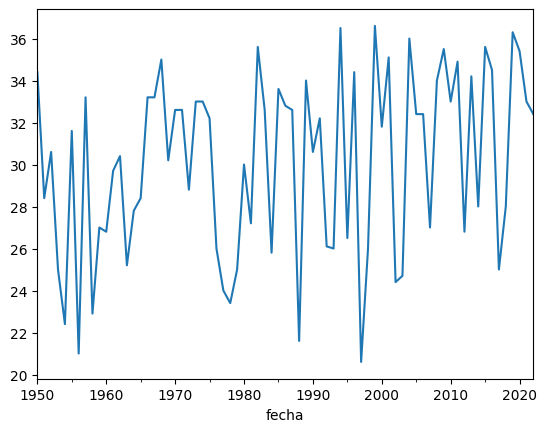

In [4]:
arr_max.sort_index().plot()

In [5]:
rain_chance

NameError: name 'rain_chance' is not defined

In [ ]:
rain_chance = get_prec_data(valid_run)

rain_chance = rain_chance.loc[rain_chance.index.dayofyear==día_año_hoy]

rain_chance = 100 * pd.DataFrame((rain_chance.apply(lambda row: sum(row != 0), axis=1) / len(rain_chance.columns)) )

rain_chance = rain_chance[rain_chance > 20].dropna().index.hour

if len(rain_chance) > 0:
    hours_list = list(map(str, rain_chance))
    if len(hours_list) > 1:
        hours_str = ", ".join(hours_list[:-1]) + " and " + hours_list[-1]
    else:
        hours_str = hours_list[0]
    output_str = f"The hours with risk are {hours_str}."
else:
    output_str = "Nothing."

print(output_str)

The hours with risk are 20, 21 and 23.


In [ ]:
string = "Datos de las " + str(valid_run+2)  +  " horas"
type(string)

str

In [ ]:
storm_chance = get_mucape_data(valid_run)

storm_chance = storm_chance.loc[storm_chance.index.dayofyear==día_año_hoy]

percentile_80 = storm_chance.apply(lambda x: x.quantile(0.8), axis=1) 

percentile_80 = percentile_80[percentile_80 > 500].index.hour


if len(percentile_80) > 0:
    hours_list = list(map(str, percentile_80))
    if len(hours_list) > 1:
        hours_str = ", ".join(hours_list[:-1]) + " and " + hours_list[-1]
    else:
        hours_str = hours_list[0]
    output_str = f"The hours with risk are {hours_str}."
else:
    output_str = "Nothing."

print(output_str)



The hours with risk are 21, 22 and 23.


In [ ]:
storm_chance.describe().T["75%"][storm_chance.describe().T["75%"]>500]

1     681.00
5     594.25
14    670.75
Name: 75%, dtype: float64

In [ ]:
np.r_[storm_chance.describe().T["75%"][storm_chance.describe().T["75%"]>500].index]

array(['1', '5', '14'], dtype=object)

In [ ]:
storm_chance.iloc[np.r_[storm_chance.describe().T["75%"][storm_chance.describe().T["75%"]>500].index]]

IndexError: positional indexers are out-of-bounds

In [ ]:
storm_chance.iloc[storm_chance.describe().T["75%"][storm_chance.describe().T["75%"]>500].index]

IndexError: positional indexers are out-of-bounds

In [ ]:
storm_chance.describe().T["75%"][storm_chance.describe().T["75%"]>500]

1     681.00
5     594.25
14    670.75
Name: 75%, dtype: float64

In [ ]:
storm_chance.describe().T["75%"]

Ctrl    310.00
1       681.00
2       275.75
3       212.75
4       272.75
5       594.25
6       432.25
7       196.25
8       469.00
9       202.00
10      400.00
11      458.00
12      183.00
13      347.50
14      670.75
15      387.00
16      260.75
Name: 75%, dtype: float64

In [ ]:
storm_chance.describe().T["75%"][storm_chance.describe().T["75%"]>500].index

Index(['1', '5', '14'], dtype='object')

In [ ]:
(storm_chance.describe().T["75%"]>500).index

Index(['Ctrl', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16'],
      dtype='object')

In [ ]:
get_mucape_data(valid_run).loc[get_mucape_data(valid_run).index.dayofyear==día_año_hoy]

,Ctrl,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Date,,,,,,,,,,,,,,,,,
2024-06-26 12:00:00+02:00,0.0,357.0,0.0,200.0,5.0,306.0,190.0,10.0,297.0,0.0,32.0,47.0,9.0,0.0,69.0,0.0,23.0
2024-06-26 13:00:00+02:00,160.0,393.0,2.0,504.0,5.0,241.0,409.0,194.0,370.0,0.0,51.0,90.0,39.0,219.0,132.0,30.0,132.0
2024-06-26 14:00:00+02:00,188.0,160.0,57.0,81.0,32.0,211.0,220.0,157.0,100.0,40.0,44.0,70.0,49.0,287.0,117.0,10.0,120.0
2024-06-26 15:00:00+02:00,69.0,0.0,114.0,0.0,3.0,211.0,115.0,122.0,172.0,84.0,57.0,373.0,328.0,0.0,188.0,37.0,69.0
2024-06-26 16:00:00+02:00,27.0,137.0,271.0,32.0,64.0,210.0,18.0,46.0,84.0,427.0,62.0,369.0,76.0,0.0,760.0,98.0,160.0
2024-06-26 17:00:00+02:00,110.0,718.0,238.0,5.0,48.0,709.0,140.0,62.0,180.0,269.0,165.0,353.0,45.0,367.0,570.0,393.0,208.0
2024-06-26 18:00:00+02:00,301.0,842.0,789.0,56.0,72.0,734.0,125.0,119.0,359.0,125.0,86.0,431.0,17.0,179.0,430.0,385.0,220.0
2024-06-26 19:00:00+02:00,202.0,611.0,374.0,11.0,216.0,1134.0,206.0,89.0,625.0,28.0,454.0,284.0,31.0,295.0,436.0,161.0,94.0
2024-06-26 20:00:00+02:00,337.0,304.0,198.0,71.0,287.0,286.0,366.0,14.0,352.0,53.0,135.0,348.0,122.0,236.0,479.0,267.0,118.0


In [ ]:
get_temp_data(valid_run)

,Ctrl,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Date,,,,,,,,,,,,,,,,,
2024-06-26 11:00:00+02:00,24.4,25.2,23.5,23.6,24.5,25.1,23.8,24.0,25.0,24.5,24.0,24.8,23.6,24.2,24.9,24.9,25.4
2024-06-26 12:00:00+02:00,25.8,26.0,24.7,25.6,26.0,25.8,25.7,26.3,26.5,25.8,25.0,26.9,25.1,24.8,26.5,25.4,25.7
2024-06-26 13:00:00+02:00,27.8,27.1,26.9,27.8,28.3,26.7,27.8,27.9,28.1,27.8,26.8,28.2,27.3,26.5,28.2,26.9,27.1
2024-06-26 14:00:00+02:00,29.2,28.3,28.6,30.1,29.9,27.6,30.0,29.7,29.2,29.3,28.5,30.9,29.0,28.6,30.3,28.4,28.2
2024-06-26 15:00:00+02:00,30.2,30.2,29.6,31.4,30.9,28.6,31.5,30.8,29.7,31.0,29.5,31.3,29.7,30.2,31.5,29.6,28.8
2024-06-26 16:00:00+02:00,31.4,31.1,30.2,32.1,33.0,29.0,31.9,31.4,30.0,32.4,31.0,30.6,28.1,31.2,32.2,29.9,29.1
2024-06-26 17:00:00+02:00,28.3,28.9,30.5,31.1,31.2,31.0,26.4,30.9,31.3,32.4,31.1,32.2,30.0,31.8,32.1,30.1,30.2
2024-06-26 18:00:00+02:00,28.0,26.7,30.1,31.3,31.5,24.1,24.5,27.4,31.9,31.5,29.4,33.1,29.4,32.5,28.6,29.3,31.6
2024-06-26 19:00:00+02:00,26.3,26.0,27.1,30.7,31.9,26.0,23.8,26.1,31.9,31.1,30.6,33.4,29.8,31.5,23.7,29.4,31.8
